<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [85]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [86]:
df = pd.read_csv( r"C:\w6_FinalAssign\loan_train.csv", 
                            encoding = "ISO-8859-1",
                            )  

### Load Data From CSV File


In [87]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [88]:
df.shape

(346, 10)

### Convert to date time object


In [89]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [90]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


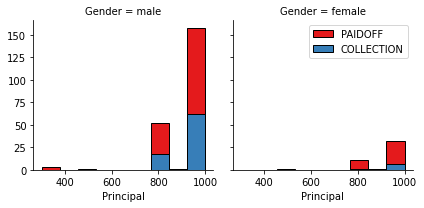

In [91]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

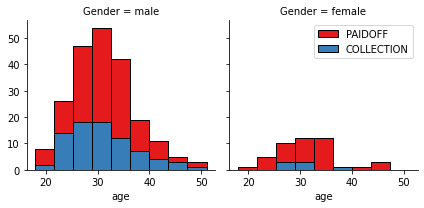

In [92]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


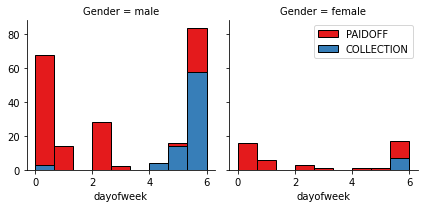

In [93]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [94]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [95]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [96]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [97]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [98]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [99]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [100]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [101]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [102]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification



Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [103]:
## Train Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [104]:
## Training 
from sklearn.neighbors import KNeighborsClassifier
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
neigh
## Predicting
yhat = neigh.predict(X_test)
yhat[0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

In [105]:
## Accuracy evaluation
from sklearn import metrics
print("Train set accuracy:", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set accuracy:", metrics.accuracy_score(y_test, yhat))

Train set accuracy: 0.8260869565217391
Test set accuracy: 0.7285714285714285


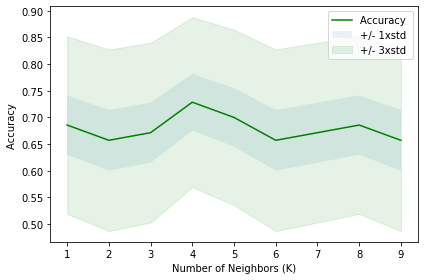

The best accuracy was with 0.7285714285714285 with k= 4


In [106]:
# Plot model accuracy for Different number of Neighbors
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

# result
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [107]:
## Model Evaulation using Jaccard with n_neighbors = 4

from sklearn.metrics import jaccard_score
from sklearn import metrics
neigh = KNeighborsClassifier(n_neighbors = 4).fit(X_train,y_train)

knn_yhat = neigh.predict(X_test)

print("train set accuracy using Jaccard:", metrics.accuracy_score(y_train, neigh.predict(X_train)))  ## predict X_train
print("test set accuracy using Jaccard:", metrics.accuracy_score(y_test, knn_yhat)) ### predict X_test

train set accuracy using Jaccard: 0.8260869565217391
test set accuracy using Jaccard: 0.7285714285714285


In [108]:
## Model Evaulation using F1_score with n_neighbors = 4
from sklearn.metrics import f1_score

print("train set accuracy using F1:", f1_score(y_train, neigh.predict(X_train), average = 'weighted')) ## predict X_train
print("test set accuracy using F1:", f1_score(y_test, knn_yhat, average = 'weighted')) ## predict X_test

train set accuracy using F1: 0.8333549643088903
test set accuracy using F1: 0.735712651567147


# Decision Tree


In [109]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
tree = tree.fit(X_train, y_train)
predTree = tree.predict(X_test)
predTree[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [110]:
### try with 10 different depth values of d to find the best one
for d in range (1, 10):
    tree = DecisionTreeClassifier(criterion="entropy", max_depth = d).fit(X_train, y_train)
    predTree = tree.predict(X_test)
    print(d, metrics.accuracy_score(y_test, predTree))

1 0.7
2 0.7
3 0.7
4 0.6857142857142857
5 0.7
6 0.6714285714285714
7 0.6714285714285714
8 0.7142857142857143
9 0.7


In [111]:
## Model Evulation - Jaccard
from sklearn.metrics import jaccard_score
from sklearn import metrics
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 1).fit(X_train, y_train)

predTree = tree.predict(X_test)

print("train set accuracy using Jaccard:", metrics.accuracy_score(y_train, tree.predict(X_train)))  ## predict X_train
print("test set accuracy using Jaccard:", metrics.accuracy_score(y_test, predTree)) ### predict X_test

train set accuracy using Jaccard: 0.7644927536231884
test set accuracy using Jaccard: 0.7


In [112]:
## Model Evaluation - F1_Score 
print("train set accuracy using F1:", f1_score(y_train, tree.predict(X_train), average = 'weighted')) ## predict X_train
print("test set accuracy using F1:", f1_score(y_test, predTree, average = 'weighted')) ## predict X_test

train set accuracy using F1: 0.6624557331190667
test set accuracy using F1: 0.5764705882352941


# Support Vector Machine


In [113]:
from sklearn import svm

for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    svm_model = svm.SVC(kernel = k)
    svm_model.fit(X_train, y_train)
    svm_predict = svm_model.predict(X_test)


In [114]:
### try with linear, poly, rft and sigmoid to find the best one

from sklearn import svm

for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    svm_model = svm.SVC(kernel = k)
    svm_model.fit(X_train, y_train)
    svm_predict = svm_model.predict(X_test)
    print("{}: the f1 score is {}" .format(k, f1_score(y_test, svm_predict, average = 'weighted')))

linear: the f1 score is 0.5694915254237288
poly: the f1 score is 0.6201739130434782
rbf: the f1 score is 0.5764705882352941
sigmoid: the f1 score is 0.5403508771929825


In [115]:
## Model Evualation - Jaccard

svm_model = svm.SVC(kernel = 'poly')
svm_model.fit(X_train, y_train)
svm_predict = svm_model.predict(X_test)

print("train set accuracy using Jaccard:", metrics.accuracy_score(y_train, svm_model.predict(X_train)))  ## predict X_train
print("test set accuracy using Jaccard:", metrics.accuracy_score(y_test, svm_predict)) ### predict X_test

train set accuracy using Jaccard: 0.7898550724637681
test set accuracy using Jaccard: 0.7


In [116]:
## Model Evulation:  F1_Score
print("train set accuracy using F1 score:", f1_score(y_train, svm_model.predict(X_train), average = 'weighted'))  ## predict X_train
print("test set accuracy using F1 score:", f1_score(y_test, svm_predict, average = 'weighted')) ### predict X_test

train set accuracy using F1 score: 0.7271183072771443
test set accuracy using F1 score: 0.6201739130434782


# Logistic Regression


In [117]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss

for s in ('liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'):
    ir_model = LogisticRegression( C=0.01, solver = s).fit(X_train, y_train)
    ir_predict = ir_model.predict(X_test)
    y_prob = ir_model.predict_proba(X_test)
    print("{}: logloss is: {}".format(s, log_loss(y_test, y_prob)))

liblinear: logloss is: 0.5858479985828119
lbfgs: logloss is: 0.5667018615828534
newton-cg: logloss is: 0.5667018510271662
sag: logloss is: 0.5666915652828808
saga: logloss is: 0.5667020027595372


In [118]:
## Model Evulation: Jaccard

ir_model = LogisticRegression(C = 0.01, solver = 'liblinear').fit(X_train, y_train)
ir_predict = ir_model.predict(X_test)
y_prob = ir_model.predict_proba(X_test)

print("train set accuracy using Jaccard:", metrics.accuracy_score(y_train, ir_model.predict(X_train)))
print("train set accuracy using Jaccard:", metrics.accuracy_score(y_test, ir_predict))

train set accuracy using Jaccard: 0.7536231884057971
train set accuracy using Jaccard: 0.7


In [119]:
## Model Evulation:  F1_score
print("train set accuracy using f1 score:", f1_score(y_train, ir_model.predict(X_train), average = 'weighted'))
print("train set accuracy using f1 score:", f1_score(y_test, ir_predict, average = 'weighted'))

train set accuracy using f1 score: 0.6800697395663071
train set accuracy using f1 score: 0.6004459308807136


In [120]:
## Model Evaulation:  

# Model Evaluation using Test set


In [121]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [122]:
test_df = pd.read_csv( r"C:\w6_FinalAssign\loan_train.csv", 
                            encoding = "ISO-8859-1",
                            )  

### Load Test set for evaluation


In [123]:

test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [126]:
## data pre-processing

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [129]:
## data pre-processing

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [130]:
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)
test_feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [132]:
## Normalize test_data
test_X = test_feature

test_X[0:5]


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [133]:
test_X = preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [134]:
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Accuracy Evaluation:  KNN

In [135]:
## Test Model Evaluation: KNN

knn_test_yhat = neigh.predict(test_X)

# jaccard
knn_test_jaccard = metrics.accuracy_score(test_y, knn_test_yhat)
print("KNN Jaccard: ", knn_test_jaccard)

# f1
knn_test_f1 = f1_score(test_y, knn_test_yhat, average = 'weighted')
print("KNN F1 Score", knn_test_f1)

KNN Jaccard:  0.8063583815028902
KNN F1 Score 0.8137553463688261


## Accuracy Evaluation:  Decision Tree

In [136]:
## Test Model Evaluation: Descision Tree
 #Train Model and Predict  
# tree_test_yhat = tree.predict(test_X)

# jaccard
tree_test_jaccard = metrics.accuracy_score(test_y, tree.predict(test_X))
print("Descision Tree Jaccard: ", tree_test_jaccard)

# f1
tree_test_f1 = f1_score(test_y, tree.predict(test_X), average = 'weighted')
print("Descision Tree F1 Score", tree_test_f1)

Descision Tree Jaccard:  0.7514450867052023
Descision Tree F1 Score 0.6448043648295465


## Accuracy Evaluation:  SVM


In [139]:
## Test Model Evaluation:  SVM
svm_test_yhat = svm_model.predict(test_X)

# jaccard
svm_test_jaccard = metrics.accuracy_score(test_y, svm_model.predict(test_X))
print("SVM Jaccard: ", svm_test_jaccard)

# f1
svm_test_f1 = f1_score(test_y, svm_model.predict(test_X), average = 'weighted')
print("SVM F1 Score", svm_test_f1)

SVM Jaccard:  0.7716763005780347
SVM F1 Score 0.7051387865232343


## Accuracy Evaluation:  Logistic Regression

In [138]:
## Test Model Evaluation:  Logistic Regression
lr_test_yhat = ir_model.predict(test_X)
lr_test_yhat_prob = ir_model.predict_proba(test_X)

# jaccard
lr_test_jaccard = metrics.accuracy_score(test_y, ir_model.predict(test_X))
print("Logistic Regression Jaccard: ", lr_test_jaccard)

# f1
lr_test_f1 = f1_score(test_y, lr_test_yhat, average = 'weighted')
print("Logistic Regression F1 Score", lr_test_f1)

#Log Loss
lr_test_logloss = log_loss(test_y, lr_test_yhat_prob )
print("Logistic Regression Log Loss:", lr_test_logloss)

Logistic Regression Jaccard:  0.7427745664739884
Logistic Regression F1 Score 0.6637715209784341
Logistic Regression Log Loss: 0.5545006888994527


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
